# NOTEBOOK 5 - Large Disturbances

#### A quick introduction ...
This notebook aims to give an explanation of large disturbances in the power system. What they are, when they occur and how they are dealt with. In contrast to small disturbances these are large in magnitude, pushing the system far away from its steady-state equilibrium. In the worst cases, large signal disturbances can cause blackouts and damages to equipment. This is why large disturbance (transient stability) analysis is so important.


Still a work in progress, if there is anything missing or you have some general feedback please contact Sjur Føyen at foyen.sjur@ntnu.no 

Outline of notebook:
- Establishing new model
- Short-circuits
- Line disconnection
- Equal Area Criterion


Code implemented by; Harald Dahn Johansen. Date; 31.01.2025

Last update; 26.02.2025

GitHub Copilot used for assistance in coding.

As always, let's start with importing relevant modules:

In [14]:
%pip install git+https://github.com/hallvar-h/tops

import sys
from collections import defaultdict
import matplotlib.pyplot as plt
import time
from IPython.display import Image
import numpy as np
from notebook_utils import power_curve, integrate_power_curve, update_plot
from ipywidgets import interact, FloatSlider


# Solver and dynamic models
from tops import dynamic as dps
from tops import solvers as dps_sol
#from tops.ps_models import ieee39

  Cloning https://github.com/hallvar-h/tops to c:\users\haral\appdata\local\temp\pip-req-build-fsz3y5mp
  Resolved https://github.com/hallvar-h/tops to commit 2daedbf4daca07d8c1e644d433a3fb27896ffbb4
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/hallvar-h/tops 'C:\Users\haral\AppData\Local\Temp\pip-req-build-fsz3y5mp'

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\haral\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


### Large disturbance examples : Short-circuits and Line-tripping

The most common types of large disturbances are caused by short-circuits and line-tripping. Both of these can be implemented in TOPS. Let's have a look at a simple model with one generator connected to an infinite grid through two identical lines:

![Figure1](Figures/twoLineSimpleDiagram.png)


The table below contains the system data used for this example.
## Table II. Parameters (all losses can be neglected):

### Generator parameters:
| Parameter  | Value       | Comment  |
|------------|------------|----------|
| *H*        | 5.0 sec    |          |
| *X_d*      | 1.0 p.u    | All per unit values are referred to <br> *V_base* = 132 kV and *S_base* = 100 MW |
| *X_d'*     | 0.3 p.u    |          |

### Generator transformer:
| Parameter  | Value       | Comment  |
|------------|------------|----------|
| *X_t*      | 0.1 p.u    | Nominal voltages: **10/132 kV** <br> Referred to *S_base* = 100 MW |

### Transmission lines:
| Parameter  | Value       | Comment  |
|------------|------------|----------|
| *X_l1*     | 0.2 p.u    | Referred to *V_base* = 132 kV and *S_base* = 100 MW |
| *X_l2*     | 0.2 p.u    | Referred to *V_base* = 132 kV and *S_base* = 100 MW |




Firstly, lets establish the model by running the block below:

In [15]:
def load_assignment_model():
    return {
        'base_mva': 100, #'base_mva': system base/nominal complex power in [MVA].
        'f': 50, #'f': system frequency in [Hz].
        'slack_bus': 'B3', #'slack_bus': reference busbar with zero phase angle.

        'buses': [
            ['name',    'V_n'],
            ['B1',         10],
            ['B2',        132],
            ['B3',        132],
        ],
        #'V_n': base/nominal voltage in [kV].

        'lines': [
            ['name',  'from_bus', 'to_bus',   'length',   'S_n',  'V_n',  'unit', 'R',    'X',   'B'],
            ['L2-3_1',        'B2',     'B3',        250,      100,    132,    'PF',   0,    0.2,     0],
            ['L2-3_2',        'B2',     'B3',        250,      110,    132,    'PF',   0,    0.2,     0],
        ],
        #'length': total line length in [km].
        #'S_n': base/nominal complex power in [MVA].
        #'V_n': base/nominal voltage in [kV].
        #'unit': chosen unit for jacobian admittance calculation (leave it as 'PF').
        #'R': line resistance in [Ohm/km].
        #'X': line reactance in [Ohm/km].
        #'B': line susceptance in [Ohm/km].

        'transformers': [
            ['name', 'from_bus', 'to_bus', 'S_n', 'V_n_from', 'V_n_to', 'R', 'X'],
            ['T1',         'B1',     'B2',    100,         10,      132,   0, 0.1],
        ],
        #'S_n': base/nominal complex power in [MVA].
        #'V_n_from': base/nominal voltage on the 'from_bus' side in [kV].
        #'V_n_to': base/nominal voltage on the 'to_bus' side in [kV].
        #'R': transformer resistance in [pu].
        #'X': transformer reactance in [pu].

        #'loads': [
        #    ['name', 'bus', 'P', 'Q', 'model'],
        #    ['L1',    'B2',  25,   0,     'Z'],  #No loads in this case
        #],
        #'P': active power delivered to the load in [MW].
        #'Q': reactive power delivered to the load in [MVAr].
        #'model': modelling of load voltage dependence (leave it as 'Z').

        'generators': {
            'GEN': [
                ['name',   'bus',  'S_n',  'V_n',    'P',    'V',      'H',    'D',    'X_d',  'X_q',  'X_d_t',    'X_q_t',    'X_d_st',   'X_q_st',   'T_d0_t',   'T_q0_t',   'T_d0_st',  'T_q0_st'],
                ['G1',      'B1',     100,     10,     80,  1.1314,      5,      0,     1.0,   0.66,    0.3,      0.66,       0.254,      0.273,       2.49,      10000,         0.06,       0.15],
                ['IB',      'B3',    1e8,    132,    -80,  1,      1e5,      0,     1.05,   0.66,    0.328,      0.66,       0.254,      0.273,       2.49,      10000,         0.06,       0.15],
            ],
        },
        # For 'IB': change only 'V_n', 'P' and 'V' if necessary. Other parameters should be left as they are.

        # 'S_n': base/nominal complex power in [MVA].
        # 'V_n': base/nominal voltage in [kV].
        # 'P': active power produced by the generator in [MW].
        # 'V': magnitude of generator terminal voltage in [pu].
        # 'H': inertia constant in [MWs/MVA].
        # 'D': damping constant in [pu-power/pu-speed].
        # 'X_d'/'X_q': synchronous d-axis/q-axis reactance in [pu].
        # 'X_d_t'/'X_q_t': transient d-axis/q-axis reactance in [pu].
        # 'X_d_st'/'X_q_st': subtransient d-axis/q-axis reactance in [pu].
        # 'T_d0_t'/'T_q0_t': open-circuit d-axis/q-axis transient time constant in [s].
        # 'T_d0_st'/'T_q0_st': open-circuit d-axis/q-axis subtransient time constant in [s].
    }

## Now, lets try to run a short-circuit on bus 1.
 Try to change the clearing time to find the maximum duration the short-circuit can last without the system going unstable. You can also change the bus at which the short-circuit occurs to see if there is any change in system response.

0.09663291938877976
99%Simulation completed in 1.23 seconds.


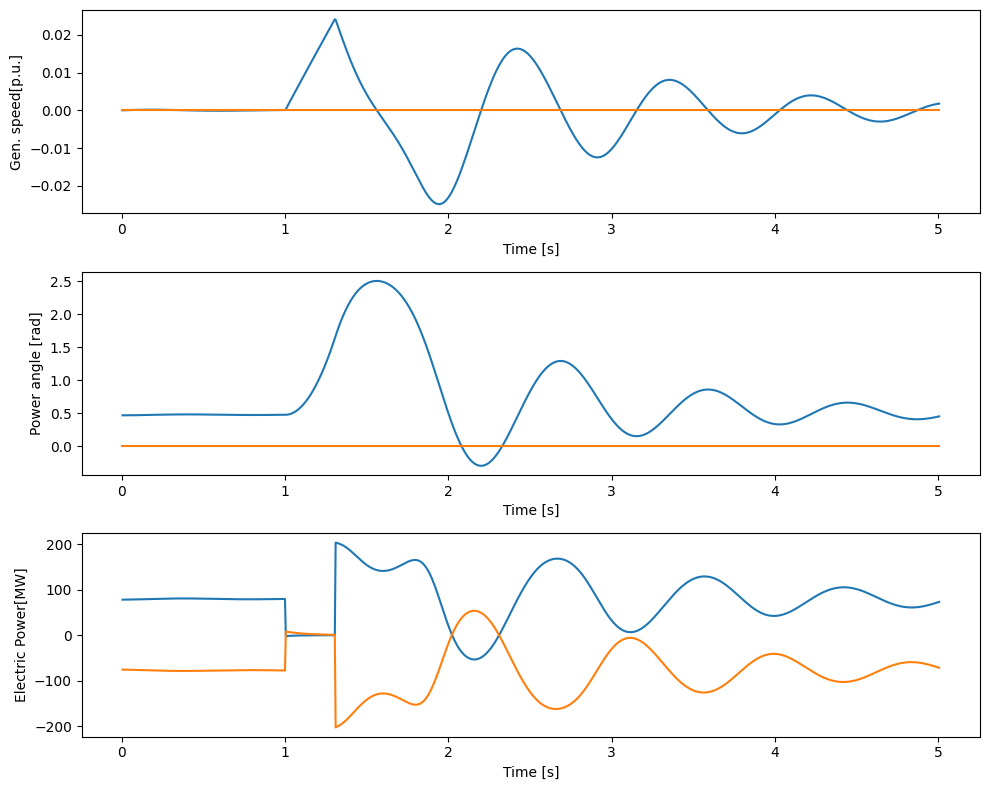

In [16]:
model = load_assignment_model()
# Power system model
ps = dps.PowerSystemModel(model=model)
ps.init_dyn_sim()
print(max(abs(ps.state_derivatives(0, ps.x_0, ps.v_0))))

t_end = 5
x_0 = ps.x_0.copy()

# Solver
sol = dps_sol.ModifiedEulerDAE(ps.state_derivatives, ps.solve_algebraic, 0, x_0, t_end, max_step=5e-3)

# Initialize simulation
t = 0
res = defaultdict(list)
t_0 = time.time()

sc_bus_idx = ps.gen['GEN'].bus_idx_red['terminal'][0]

# Run simulation
while t < t_end:
    sys.stdout.write("\r%d%%" % (t/(t_end)*100))

    ################  Assignment 3 / 4: Simulation of short-circuit  ################

    t_fault = 1
    t_clear = 1.3

    if (t_fault<t<t_clear):
        ps.y_bus_red_mod[1,1] =1e6
    else:
        ps.y_bus_red_mod[ 1, 1] =0
    #'y_bus_red_mod' refers to the fault admittance, the inverse of fault impedance.
    #Fault: impedance = zero --> admittance = ?

    #[0, 0]: corresponds to 'B1' (generator bus).
    #[1, 1]: corresponds to 'B2'
    #[2, 2]: corresponds to 'B3' (stiff network).


    # Simulate next step
    result = sol.step()
    x = sol.y
    v = sol.v
    t = sol.t

    dx = ps.ode_fun(0, ps.x_0)

    # Store result
    res['t'].append(t)
    res['gen_speed'].append(ps.gen['GEN'].speed(x, v).copy())
    res['power_angle'].append(ps.gen['GEN'].angle(x, v).copy())
    res['Electric Power'].append(ps.gen['GEN'].P_e(x, v).copy())

print('Simulation completed in {:.2f} seconds.'.format(time.time() - t_0))

fig, axs = plt.subplots(3, 1, figsize=(10, 8))

# Plot generator speed
axs[0].plot(res['t'], res['gen_speed'])
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel('Gen. speed[p.u.]')

# Plot power angle
axs[1].plot(res['t'], res['power_angle'])
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('Power angle [rad]')

# Plot electric power
axs[2].plot(res['t'], res['Electric Power'])
axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('Electric Power[MW]')

# Adjust layout
plt.tight_layout()
plt.show()

## Now, lets try disconnecting one of the lines.
 To minimize the damage, protection gear disconnects the faulty line. This can be simulated in the block below. Try to change the time at which the line reconnects. Does this have an affect on the stability of the system?

0.0966329193887707
99%Simulation completed in 1.33 seconds.


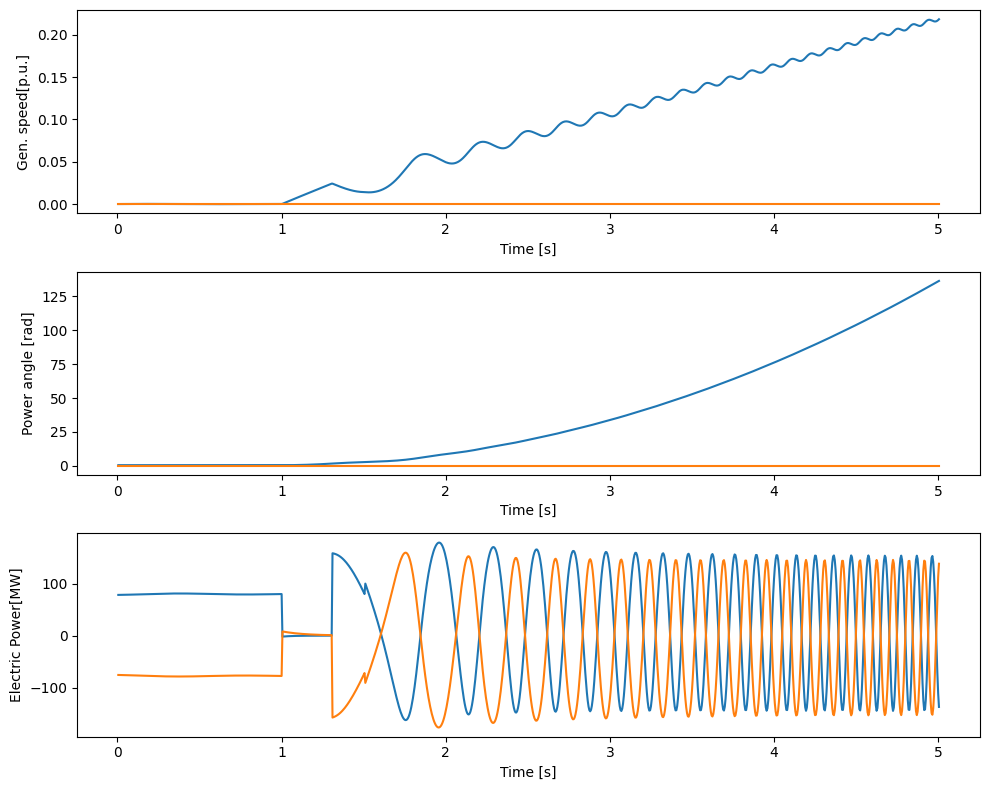

In [17]:
model = load_assignment_model()
# Power system model
ps = dps.PowerSystemModel(model=model)
ps.init_dyn_sim()
print(max(abs(ps.state_derivatives(0, ps.x_0, ps.v_0))))

t_end = 5
x_0 = ps.x_0.copy()

# Solver
sol = dps_sol.ModifiedEulerDAE(ps.state_derivatives, ps.solve_algebraic, 0, x_0, t_end, max_step=5e-3)

# Initialize simulation
t = 0
res = defaultdict(list)
t_0 = time.time()

sc_bus_idx = ps.gen['GEN'].bus_idx_red['terminal'][0]

eventflag1=True
eventflag2=True
eventflag3=True
t_fault=1
t_clear=1.3
t_line_connect=1.5


# Run simulation
while t < t_end:
    sys.stdout.write("\r%d%%" % (t/(t_end)*100))

    #####  Assignment 5/6: Short-circuit with line disconnection & reconnection #####

    if (t_fault<t<=t_clear) and eventflag1:
       eventflag1=False
       ps.y_bus_red_mod[1,1] = 1e6

    if (t_clear<t<=t_line_connect) and eventflag2:
        eventflag2=False
        ps.lines['Line'].event(ps, ps.lines['Line'].par['name'][0], 'disconnect')
        ps.y_bus_red_mod[1,1] =0

    if (t_line_connect<t) and (eventflag3):
        eventflag3=False
        ps.lines['Line'].event(ps, ps.lines['Line'].par['name'][0], 'connect')

    #################################################################################

    # Simulate next step
    result = sol.step()
    x = sol.y
    v = sol.v
    t = sol.t

    dx = ps.ode_fun(0, ps.x_0)

    # Store result
    res['t'].append(t)
    res['gen_speed'].append(ps.gen['GEN'].speed(x, v).copy())
    res['power_angle'].append(ps.gen['GEN'].angle(x, v).copy())
    res['Electric Power'].append(ps.gen['GEN'].P_e(x, v).copy())

print('Simulation completed in {:.2f} seconds.'.format(time.time() - t_0))

fig, axs = plt.subplots(3, 1, figsize=(10, 8))

# Plot generator speed
axs[0].plot(res['t'], res['gen_speed'])
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel('Gen. speed[p.u.]')

# Plot power angle
axs[1].plot(res['t'], res['power_angle'])
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('Power angle [rad]')

# Plot electric power
axs[2].plot(res['t'], res['Electric Power'])
axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('Electric Power[MW]')

# Adjust layout
plt.tight_layout()
plt.show()

    





    

# The Equal Area Criterion

As for small signal disturbances, we use the power-angle characteristics of the generator to investigate the systems response to transient disturbances. To determine wether or not a generator is unstable we compare the energy gained by the machine during a fault (acceleration stage), to the energy lost during the post-fault (deceleration) stage.
 If the accelaration energy is larger than the deceleration energy, it means that the generator is not able to recover the rotor, leading to an unstable system.

To investigate this criterion, let us use the same line diagram as previously implemented in this notebook:

![Figure1](Figures/twoLineSimpleDiagram.png)


The table below contains the system data used for this example.
#### Table II. Parameters (all losses can be neglected):

#### Generator parameters:
| Parameter  | Value       | Comment  |
|------------|------------|----------|
| *H*        | 5.0 sec    |          |
| *X_d*      | 1.0 p.u    | All per unit values are referred to <br> *V_base* = 132 kV and *S_base* = 100 MW |
| *X_d'*     | 0.3 p.u    |          |

#### Generator transformer:
| Parameter  | Value       | Comment  |
|------------|------------|----------|
| *X_t*      | 0.1 p.u    | Nominal voltages: **10/132 kV** <br> Referred to *S_base* = 100 MW |

#### Transmission lines:
| Parameter  | Value       | Comment  |
|------------|------------|----------|
| *X_l1*     | 0.2 p.u    | Referred to *V_base* = 132 kV and *S_base* = 100 MW |
| *X_l2*     | 0.2 p.u    | Referred to *V_base* = 132 kV and *S_base* = 100 MW |


## Large Disturbance Example
A three-phase-to-ground symmetrical short circuit fault occurs on transmission line 2. The fault
impedance is such that we can assume that the electrical power produced during the short circuit
is 20 MW (assumed constant).
The fault is successfully cleared by tripping line 2 after 0.1 seconds. Find out if the system remains stable after this event.

Recall the transient power-angle characteristic from notebook 4 on small disturbances, which for a round rotor ($x_d=x_q$) is given by:
$$
P_e' = P_{Eq}' = \frac{|E_q'| |V_s|}{x_d'} \sin \delta' 
$$
Using the parameters given in Table II, lets first calculate and plot the characteristic before the fault:





E= (1.1099999999999999+0.43999999999999995j)


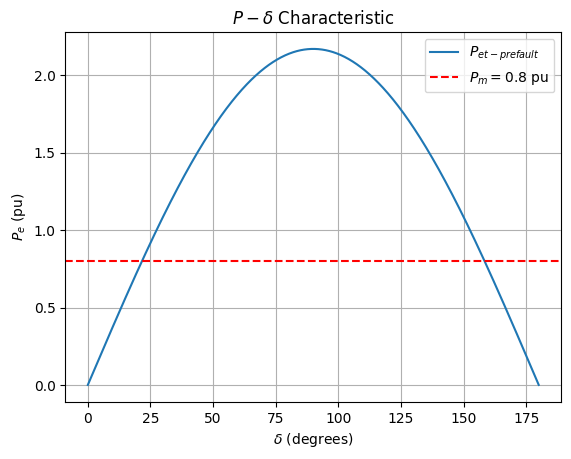

In [18]:
X_d=1.0     #p.u.
X_dt=0.3    #p.u.
X_t=0.15    #p.u.
X_l1=0.2    #p.u.
X_l2=0.2    #p.u.   
P=0.8       #p.u.
Q=0.2       #p.u.
Sn=100      #MVA
Vs=1        #p.u.
P_m=0.8     #p.u.
P_e_sc=0.2  #p.u.
f_n=50      #Hz
H=5         #s
t_clear=0.2 #s
delta = np.linspace(0, np.pi, 1000)
delta_deg = np.degrees(delta)


x_dt=X_dt+X_t+(X_l1*X_l2)/(X_l1+X_l2)   #p.u.
S= (P+1j*Q)         #p.u. 
I= np.conj(S/Vs)             #p.u.
E=Vs+1j*x_dt*I

P_Et_prefault=(abs(E)*abs(Vs)/x_dt)*np.sin(delta)
delta_0 = np.degrees(np.angle(E))  # Calculate delta_0 in degrees
print("E=",E)
plt.figure()
plt.plot(delta_deg, P_Et_prefault, label='$P_{et-prefault}$')
plt.xlabel(r'$\delta$ (degrees)')
plt.ylabel(r'$P_e$ (pu)')
plt.title(r'$P-\delta$ Characteristic')
plt.grid(True)
plt.axhline(y=P_m, color='r', linestyle='--', label=r'$P_m = 0.8$ pu')
plt.legend()
plt.show()


During the fault, $P_E'(\delta')=0.2 [p.u.]$ is delivered to the grid, and a lot of the turbine power contributes to the acceleration of the rotor:
$$
\Delta P = P_M - P_E'(\delta') = 0.8-0.2 = 0.6 [p.u.]
$$

After disconnecting the line, the resulting transient d-axis reactance changes. This gives a new power-angle characteristic:


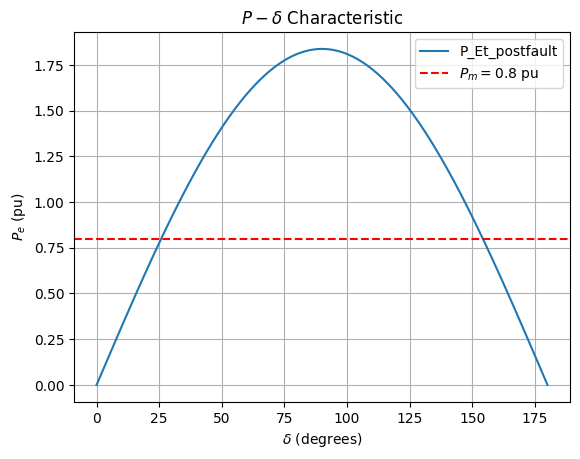

In [19]:
x_dt_post=X_dt+X_t+X_l1   #one of the lines are now disconnected, and so we must recalculate x_dt for the postfault condition


P_Et_postfault=(abs(E)*abs(Vs)/x_dt_post)*np.sin(delta)

plt.figure()
plt.plot(delta_deg, P_Et_postfault, label='P_Et_postfault')
plt.xlabel(r'$\delta$ (degrees)')
plt.ylabel(r'$P_e$ (pu)')
plt.title(r'$P-\delta$ Characteristic')
plt.grid(True)
plt.axhline(y=P_m, color='r', linestyle='--', label=r'$P_m = 0.8$ pu')
plt.legend()
plt.show()         

To find the different areas, we need to find the angle the rotor reaches before the fault is cleared, which in this case is 0.2 seconds. Recall from notebook 4 on small disturbances the swing equation, which in p.u. was expressed as 
$$ \frac{2 H}{\omega_N} \frac{d^2\delta}{dt^2} = P_m - P_e (\delta) - D_d \frac{d\delta}{dt} $$
Transient stability focuses on short-term dynamics (a few cycles/seconds). In this timespace the damping effects are relatively small compared to the inertial and power exchange effects, and the term can therefore be neglected from this equation. Moreover, we are now interested in the transient angle, denoted $\delta'$ instead of $\delta$. This leaves:

$$ \frac{2 H}{\omega_N} \frac{d^2\delta'}{dt^2} = P_m - P_e (\delta') $$

During the short circuit, the mechanical power $P_m$ remains 0.8 p.u., while the electrical power $P_E'(\delta')$ is 0.2 p.u. (as described in the text). The swing equations gives
$$ \frac{2 H}{\omega_n} \frac{d^2\delta'}{dt^2} = P_m-P_E'(\delta')=0.6$$
which integrated gives

$$\dot{\delta'} = \int_{0}^{t} (P_m-P_E'(\delta')) \cdot \frac{\pi f_N}{H} dt = \dot{\delta'}_0 + \frac{(P_m-P_E'(\delta')) \pi f_N}{H} \cdot t$$

The initial rate of change of rotor angle is zero, i.e. $$\dot{\delta'}_0 = \dot{\delta'}(t = 0) = 0$$.  
Integrating further gives  

$$\delta' = \int_{0}^{t} \frac{(P_m-P_E'(\delta') \pi f_N}{H} \cdot t \, dt = \delta'_0 + \frac{(P_m-P_E'(\delta')) \pi f_N}{H} \cdot \frac{1}{2} t^2$$

We know the initial rotor angle $\delta'_0$ from the angle of the pre-fault internal generated voltage.  
Let's calculate the clearing angle by putting in the values:


In [20]:
delta_0_rad=np.deg2rad(delta_0)
delta_clear_rad=delta_0_rad+((P_m-P_e_sc)*np.pi*f_n/H)*0.5*t_clear**2  #Angle at the time of fault clearing
print("delta_0=",delta_0_rad)
print("delta_clear=",delta_clear_rad)

delta_0= 0.3773959672364248
delta_clear= 0.7543870856672001


The acceleration and deceleration energies are calculated by finding the areas under the respective curves. In the acceleration period the electric power is zero, and so the area is calculated by multiplying the mechanical power by the angle difference:
$$A_1=P_m*(\delta'_0-\delta'_{clear})$$ 
The deceleration area is calculated by integrating the new power-angle characteristic from the angle of line clearance to the angle at which the power balance is restored.
$$\delta_{end}=\arcsin(\frac{P_m\cdot x_d'}{|E_q'||V_s|})$$
$$A_2=\int_{\delta'_{clear}}^{\delta'_{end}}(\frac{|E_q'| |V_s|}{x_d'} \sin \delta'-P_m) d\delta$$

Lets calculate these using python. Use the sliders in the plot below to see how different parameters affect the power curve, and consequently the fulfillment of the Equal Area Criterion. (Use disgression when moving the sliders as some combinations give unrealistic circumstances.)

In [21]:
delta_end_rad=np.pi-np.arcsin(P_m*x_dt/(abs(E)*abs(Vs)))  #End angle
A_1=(P_m-P_e_sc)*(delta_clear_rad-delta_0_rad)  #Area 1
A_2=integrate_power_curve(delta_clear_rad, delta_end_rad, P_m, E, Vs, x_dt)-P_m*(delta_end_rad-delta_clear_rad)  #Area 2
print("For the initial case:")
print("Area 1: ", A_1)
print("Area 2: ", A_2)


# Create sliders for the parameters
delta_clear_slider = FloatSlider(min=0, max=np.pi, step=0.05, value=np.pi/4, description='delta_clear')
P_m_slider = FloatSlider(min=0.1, max=2.0, step=0.1, value=P_m, description='P_m')
E_slider = FloatSlider(min=0.1, max=2.0, step=0.1, value=abs(E), description='E')
Vs_slider = FloatSlider(min=0.1, max=2.0, step=0.1, value=Vs, description='Vs')
x_dt_slider = FloatSlider(min=0.1, max=2.0, step=0.05, value=x_dt_post, description='x_dt')

# Create an interactive plot
interact(update_plot, delta_clear=delta_clear_slider, P_m=P_m_slider, P_e_sc=P_e_sc, E=E_slider, Vs=Vs_slider, x_dt=x_dt_slider)


For the initial case:
Area 1:  0.22619467105846522
Area 2:  1.9922924942777938


interactive(children=(FloatSlider(value=0.7853981633974483, description='delta_clear', max=3.141592653589793, …

<function notebook_utils.update_plot(delta_clear, P_m, P_e_sc, E, Vs, x_dt)>

## Conclusions
As we can see, the power system is stable for our case. Feel free to use the sliders on the plot above to find the critical angle for this system. Can you use the swing equation to calculate the critical time?


This notebook only deals with a simple case of a large disturbance to give an intuitive understanding of the EAC. It is important to note that there are other cases, such as unsymmetrical faults and faults with local loads, where the calculations will be somewhat different from what has been shown here. Have a look at the course slides or the chapter on large disturbances in the textbook to get a full understanding of this.